# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
import warnings
warnings.filterwarnings("ignore")

##### 1) Загрузка данных и визуальный анализ (1 балл)

Загрузите данные из файла atm.csv. Рекомендуется для нормальной работы некоторых фукнций перевести индекс в тип PeriodIndex. Например, можно создать date_range с нужной частотой. Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

In [2]:
# ༼ つ ◕_◕ ༽つ
atm = pd.read_csv('atm.csv')

In [3]:
atm.dtypes

Unnamed: 0     object
target        float64
dtype: object

In [4]:
len(atm)

986

In [5]:
sum(pd.to_datetime(atm['Unnamed: 0']) == pd.date_range(start='2015-01-01', end='2017-09-12', freq='D')) 

986

In [6]:
atm.index = pd.date_range(start=atm['Unnamed: 0'].iloc[0], end=atm['Unnamed: 0'].iloc[-1], freq='D')

In [7]:
atm.drop('Unnamed: 0',axis=1, inplace=True)

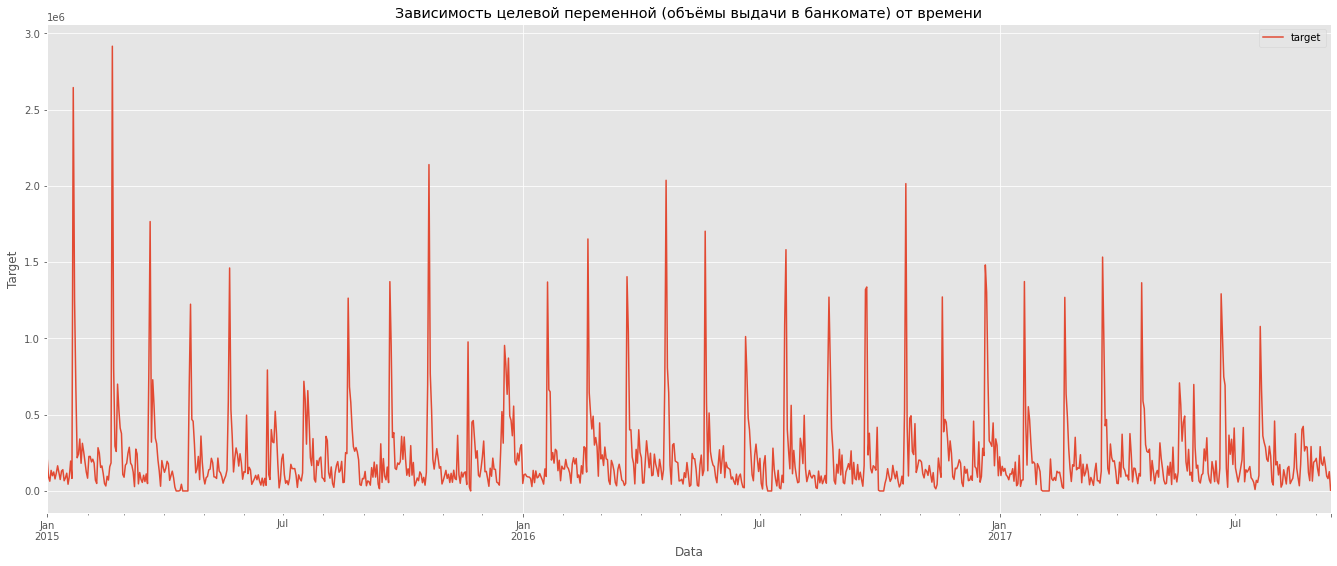

In [8]:
atm.plot();
plt.title('Зависимость целевой переменной (объёмы выдачи в банкомате) от времени')
plt.ylabel('Target')
plt.xlabel('Data');

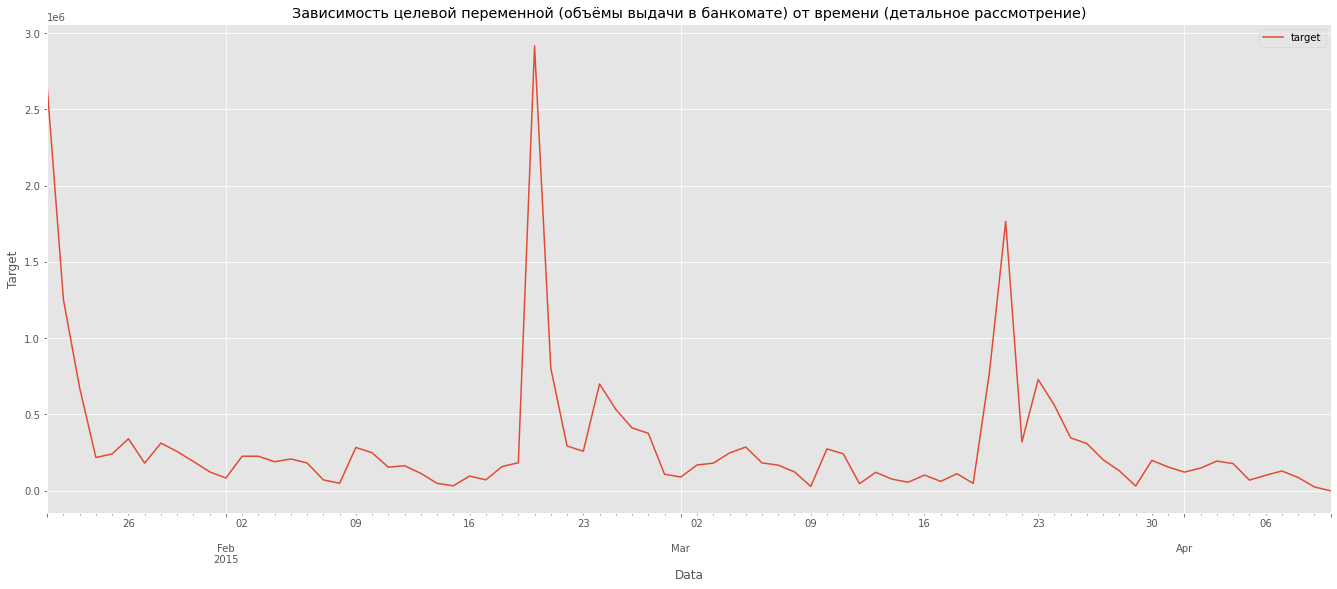

In [9]:
atm[20:100].plot()
plt.title('Зависимость целевой переменной (объёмы выдачи в банкомате) от времени (детальное рассмотрение)')
plt.ylabel('Target')
plt.xlabel('Data');

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

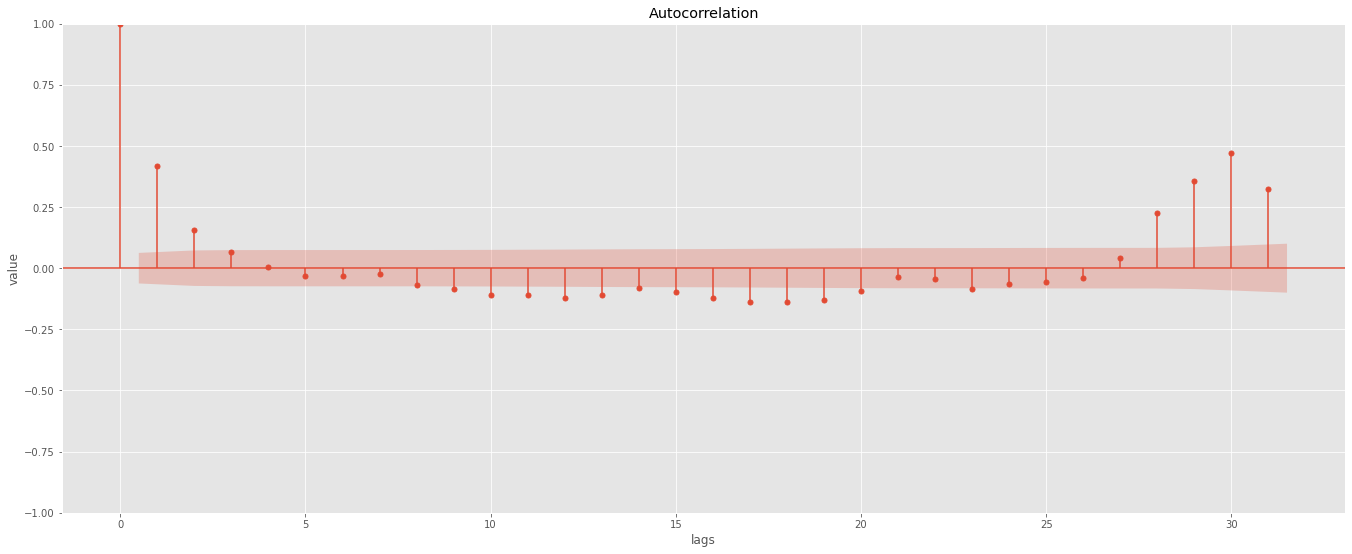

In [11]:
plot_acf(atm,lags=31)
plt.xlabel('lags')
plt.ylabel('value');

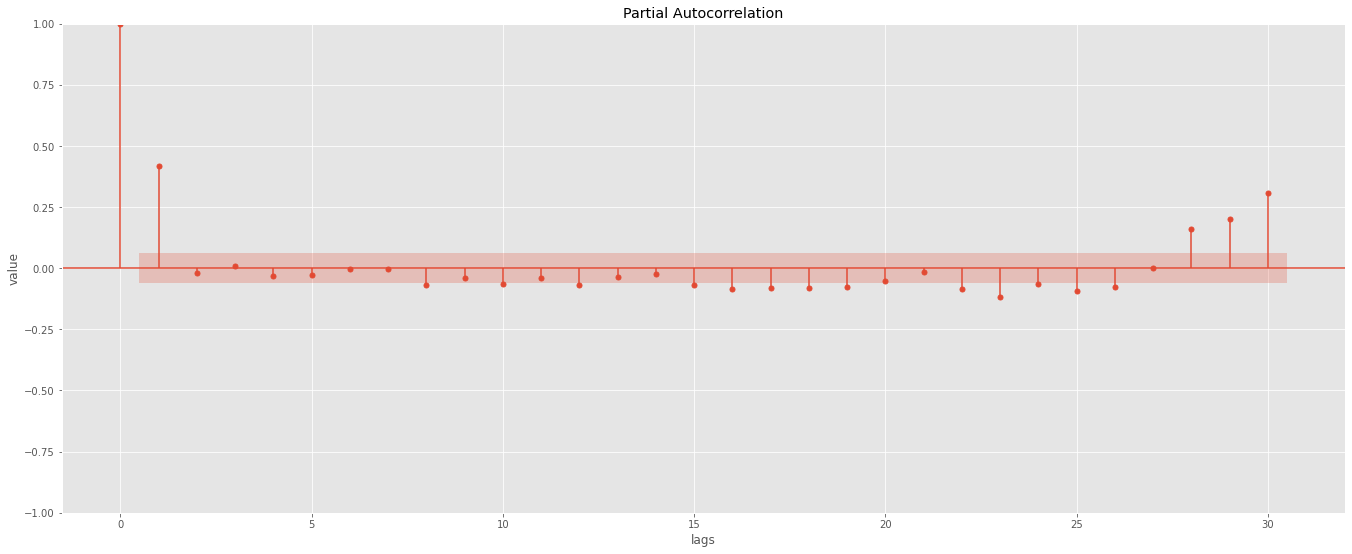

In [12]:
plot_pacf(atm,lags=30)
plt.xlabel('lags')
plt.ylabel('value');

Из графика временного ряда можно заключить, что он не имеет тренда, есть сезонность (судя по графикам корреляций с частотой в 30 дней), возможно есть цикличность (можно ее заметить в высоте пиков временного ряда, то есть можно наблюдать, сильный всплеск, далее идет спад в величинах сплеска, затем подъём и снова большой всплеск).
Ряд нестационарен (из-за ярко выраженной сезонности)

##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 30 дней.

Как легко заметить, данные неотрицательны. Но давайте на случай использования мультипликативных ETS-моделей их децентрируем. К тренировочной части прибавьте произвольную небольшую константу (например 100 рублей). Обратите внимание, что константу придётся вычесть из прогнозов итоговой модели при подсчёте метрик относительно теста.

Дополнительно можете произвести обратимые преобразования, которые сочтёте необходимыми.

In [262]:
import statsmodels.tsa.exponential_smoothing

In [263]:
# ༼ つ ◕_◕ ༽つ
from sktime.forecasting.all import temporal_train_test_split

In [264]:
y_train, y_test =  temporal_train_test_split(y = atm['target'], test_size=30)

In [265]:
y_train_decentr = y_train + 100

## Покомпонентное прогнозирование

В данном разделе мы попробуем пофильтровать ряд с помощью двух моделей: STL-разложения и ETS-модели.

### Блок 1. STL

##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL-разложение. В качестве параметра period возьмите самый сильный лаг автокорреляций. Визуализируйте отдельные компоненты.

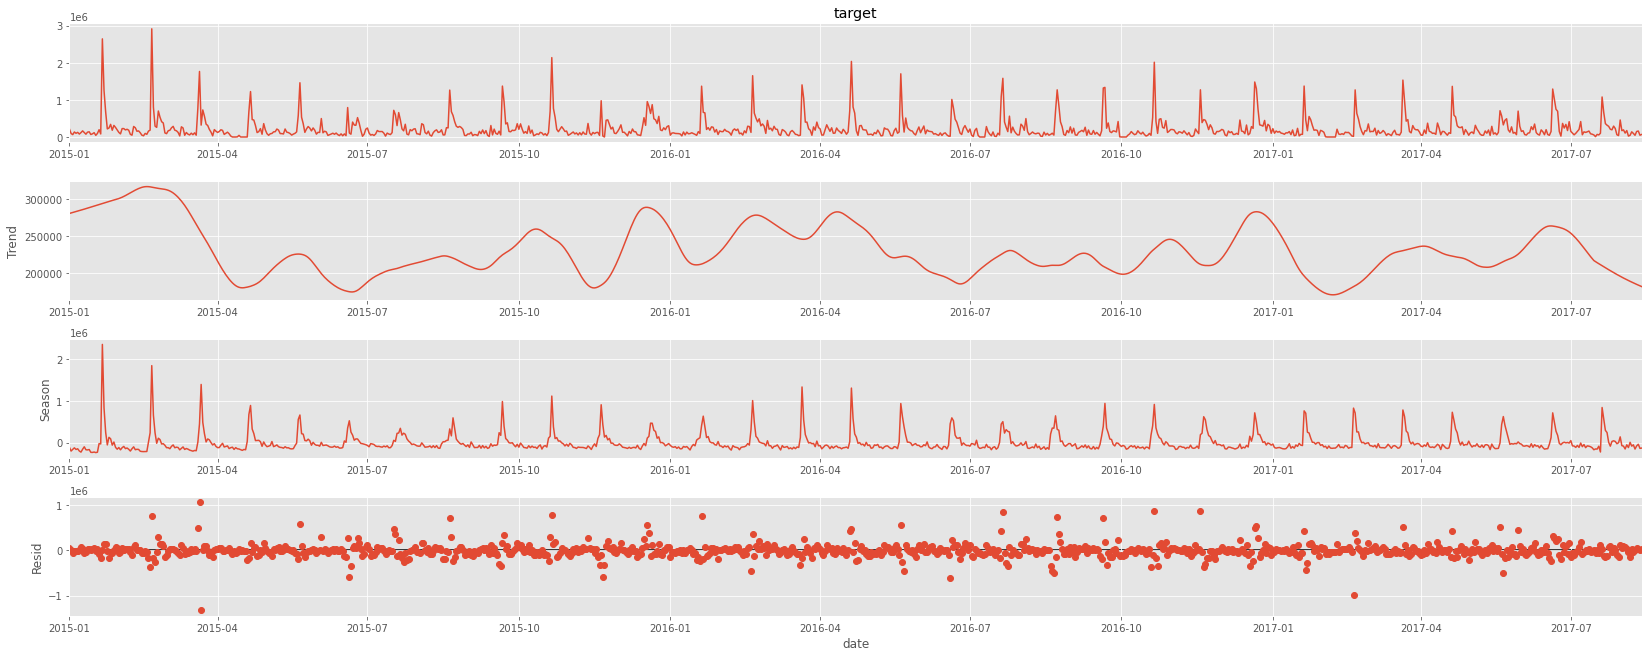

In [266]:
# ༼ つ ◕_◕ ༽つ
from statsmodels.tsa.seasonal import STL

stl = STL(y_train_decentr, period = 30).fit()
stl.plot();
plt.xlabel('date');

In [267]:
season = stl.seasonal
trend = stl.trend
residuals = stl.resid

##### Прогнозирование отдельных компонент (0.6 балла)

Возьмём выделенные из STL компоненты. Постройте какие-нибудь простые модели (без фичей) для тренда и сезонности.

Например, для тренда можно взять модель полиномального тренда из sktime. Для сезонности можно использовать NaiveForecaster с указанием периодичности. Спрогнозируйте каждую компоненту 30 шагов (по 0.3 за каждую компоненту).

In [268]:
# ༼ つ ◕_◕ ༽つ
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.naive import NaiveForecaster
poltrend = PolynomialTrendForecaster(degree = 5)
poltrend.fit(trend)

PolynomialTrendForecaster(degree=5)

In [269]:
from sktime.forecasting.base import ForecastingHorizon
fh1 = ForecastingHorizon(trend.index, is_relative=False)

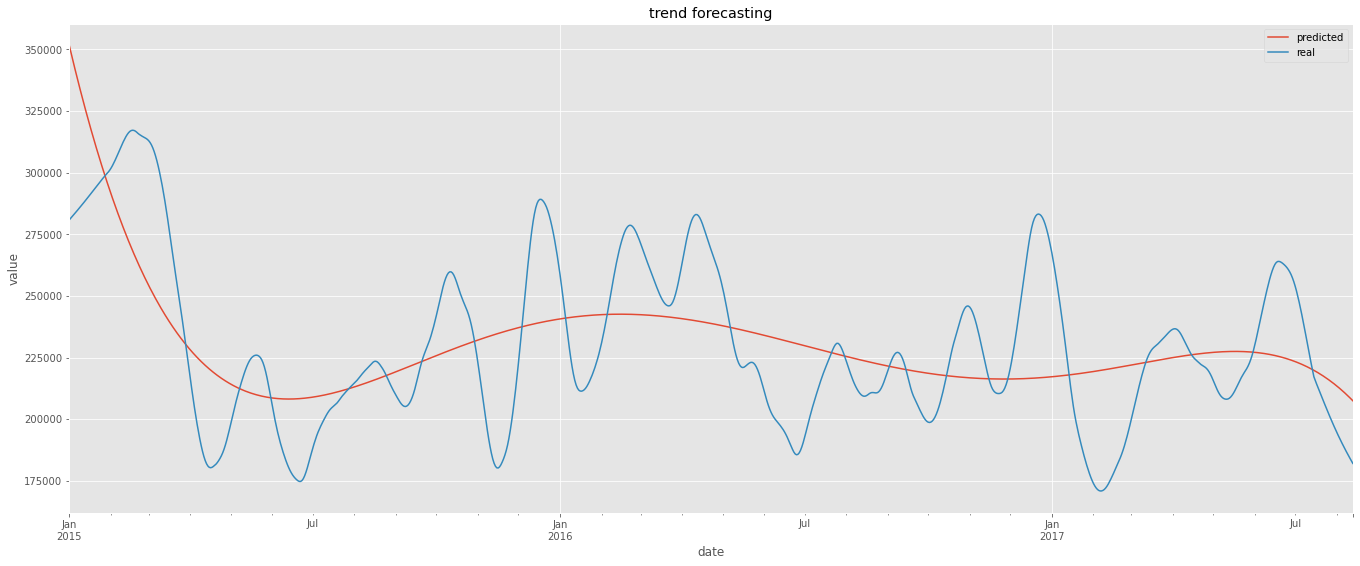

In [270]:
poltrend.predict(fh=fh1).plot()
trend.plot()
plt.legend(['predicted', 'real'])
plt.title('trend forecasting')
plt.xlabel('date')
plt.ylabel('value');

In [271]:
forecaster = NaiveForecaster(strategy="last", sp=30)
forecaster.fit(season)

NaiveForecaster(sp=30)

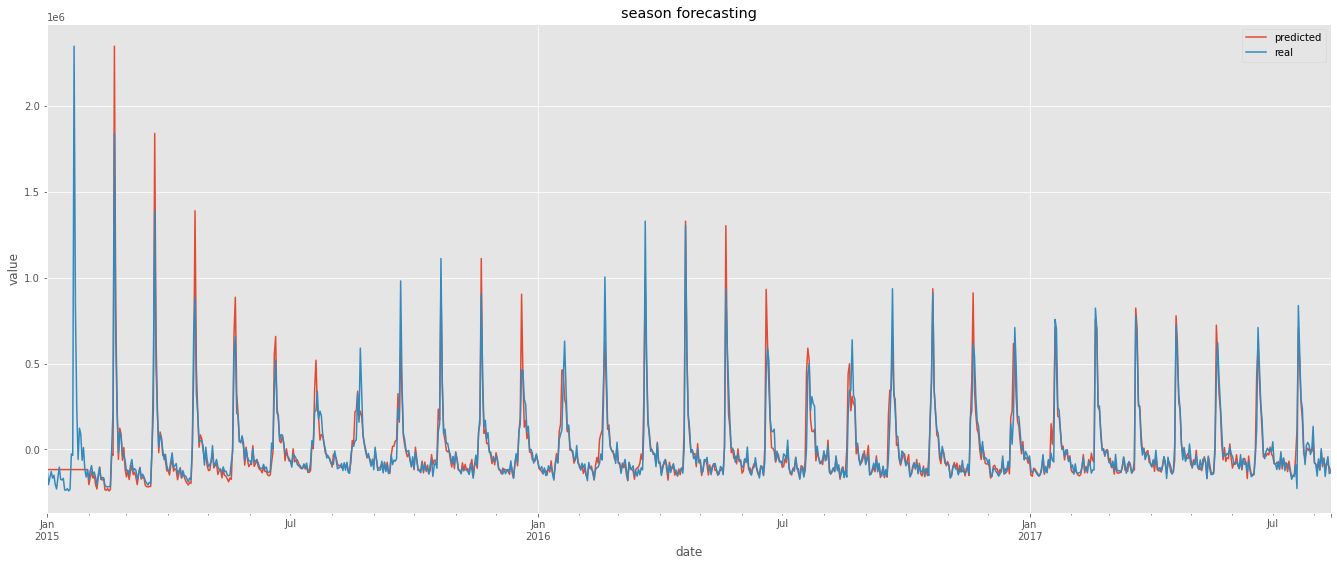

In [272]:
forecaster.predict(fh=fh1).plot()
season.plot();
plt.legend(['predicted', 'real'])
plt.title('season forecasting')
plt.xlabel('date')
plt.ylabel('value');

Строим прогнозы

In [273]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
season_pred = forecaster.predict(fh=fh)
trend_pred = poltrend.predict(fh=fh)

#### Прогнозирование остатков. 

##### Подготовка данных (0.9 балла)

Достанем временной ряд остатков из STL-разложения. Построим отдельную модель с остатками STL в качестве таргета и потом сложим с прогнозами отдельных компонент из предыдущего шага. Получим этакий бутерброд. Прогнозируем отдельно на 30 шагов каждую компоненту: тренд, сезонность и ошибку, а потом суммируем прогнозы.

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение.

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

In [326]:
# ༼ つ ◕_◕ ༽つ
df = pd.DataFrame({'residuals':residuals}, index = atm.index)

In [327]:
df

,residuals
2015-01-01,49573.862469
2015-01-02,17813.153048
2015-01-03,-54425.095030
2015-01-04,-19414.996739
2015-01-05,-16933.053287
...,...
2017-09-08,NaN
2017-09-09,NaN
2017-09-10,NaN
2017-09-11,NaN


In [328]:
events = pd.read_csv('events.csv')

In [329]:
events.index = pd.to_datetime(events[events.columns[0]])
events.drop(events.columns[0], axis = 1, inplace = True)

In [330]:
events = events[df.index[0]: df.index[-1]]

In [331]:
df1 = df.merge(events[['предвыходной рабочий день', 'выходной','фпрель','май','июнь','июль','август']], how = 'left', right_index=True, left_index=True)

Признак 'теплые деньки' введен по предположению, что в парках (банкомат находится в Парке Горького) больше народу в теплое время года в нерабочие дни => большему количеству людей может быть нужно обналичить деньги.

In [332]:
df1['теплые деньки'] = np.sum(df1[['фпрель','май','июнь','июль','август']],axis=1) * df1['выходной']

Признак 'ключевая ставка' (https://cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=19.06.2020): в целом влияет на денежный спрос, в тоерии может влиять на показатели объёма выданных банкоматои денег.

In [333]:
df_n = pd.DataFrame({'stavka':np.array([0]*len(atm))}, index = atm.index)
df_n

,stavka
2015-01-01,0
2015-01-02,0
2015-01-03,0
2015-01-04,0
2015-01-05,0
...,...
2017-09-08,0
2017-09-09,0
2017-09-10,0
2017-09-11,0


In [334]:
# собрано вручную с помощью сайта https://cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=19.06.2020
df_n['2015-01-01':'2015-02-01'] = 17
df_n['2015-02-02':'2015-03-15'] = 15
df_n['2015-03-16':'2015-05-04'] = 14
df_n['2015-05-05':'2015-06-15'] = 12.5
df_n['2015-06-16':'2015-08-02'] = 11.5
df_n['2015-08-03':'2016-06-13'] = 11
df_n['2016-06-14':'2016-09-18'] = 10.5
df_n['2016-09-19':'2017-03-26'] = 10
df_n['2017-03-27':'2017-05-01'] = 9.75
df_n['2017-05-02':'2017-06-18'] = 9.25
df_n['2017-06-19':] = 9

In [335]:
df_n = df_n.shift(1)

In [336]:
df_n

,stavka
2015-01-01,NaN
2015-01-02,17.0
2015-01-03,17.0
2015-01-04,17.0
2015-01-05,17.0
...,...
2017-09-08,9.0
2017-09-09,9.0
2017-09-10,9.0
2017-09-11,9.0


In [337]:
df_s = df1.merge(df_n, how='left', right_index=True, left_index=True) #

Курс доллара (особенно его динамика) могут стать ключевым, влияющем на спрос наличности банкомата)))

In [338]:
usd = pd.read_csv('USD.csv',sep = ';')[['<CLOSE>', '<DATE>']]

In [339]:
usd['<DATE>'] = pd.to_datetime(usd['<DATE>'].apply(lambda x: '{}'.format(x)).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:]))

In [340]:
df_a = df_s.merge(usd , how = 'left', right_on = '<DATE>',left_index = True)
df_a.index = atm.index

In [341]:
df_a['<CLOSE>'] = df_a['<CLOSE>'].interpolate().shift(1)

In [342]:
df_a.drop('<DATE>', axis = 1, inplace = True)

Дни заработной платы - люди постарше предпочитают снимать тут же свою заработную плату при ее получении

In [343]:
df_a['wage'] = (df_a.index.day == 30) *1

In [344]:
X_train, y_train =df_a.dropna().drop('residuals',axis=1)[0:len(y_train_decentr)],df_a.dropna()['residuals'][0:len(y_train_decentr)]

In [345]:
X_test = df_a[len(y_train_decentr):].drop('residuals', axis=1)

In [346]:
X_train

,предвыходной рабочий день,выходной,фпрель,май,июнь,июль,август,теплые деньки,stavka,<CLOSE>,wage
2015-01-02,0,1,0,0,0,0,0,0,17.0,56.237600,0
2015-01-03,0,1,0,0,0,0,0,0,17.0,56.779158,0
2015-01-04,0,1,0,0,0,0,0,0,17.0,57.320717,0
2015-01-05,0,1,0,0,0,0,0,0,17.0,57.862275,0
2015-01-06,0,1,0,0,0,0,0,0,17.0,58.403833,0
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-09,0,0,0,0,0,0,1,0,9.0,60.060500,0
2017-08-10,0,0,0,0,0,0,1,0,9.0,59.988600,0
2017-08-11,1,0,0,0,0,0,1,0,9.0,59.961100,0
2017-08-12,0,1,0,0,0,0,1,1,9.0,59.929800,0


#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков STL на трейне. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Так как нас интересуют именно многошаговые прогнозы, стандартная кросс-валидация нам не подойдёт. Выберите любой из двух методов кросс-валидации временных рядов (скользящее или расширяющееся окно) на ваше усмотрение.

 Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Ширина окна 35 при горизонте 30 -- сомнительная практика.


In [295]:
class CustomCrossVal:
    def __init__(self, window_size = 100, step=30):

        '''Args:
            window_size (int): The size of window. For expanding window -- initial size of window
            step (int): Window step. For expanding window is a growth of window. For sliding window is number of obs to slide.
        '''
        self.window_size = window_size
        self.step = step

    def split(self, X):
        '''Args:
            X (pandas DataFrame): Dataframe to split.
           '''
        initial = self.window_size
        index = []
        while (initial + self.step) <= len(X):
                index.append((initial, initial+self.step))
                initial+=self.step
        return index

In [296]:
c = CustomCrossVal(100,30) 

In [297]:
c = c.split(df_s)

In [298]:
c

[(100, 130),
 (130, 160),
 (160, 190),
 (190, 220),
 (220, 250),
 (250, 280),
 (280, 310),
 (310, 340),
 (340, 370),
 (370, 400),
 (400, 430),
 (430, 460),
 (460, 490),
 (490, 520),
 (520, 550),
 (550, 580),
 (580, 610),
 (610, 640),
 (640, 670),
 (670, 700),
 (700, 730),
 (730, 760),
 (760, 790),
 (790, 820),
 (820, 850),
 (850, 880),
 (880, 910),
 (910, 940),
 (940, 970)]

##### Отбор моделей (0.5 балла)

Выберите 3-4 модели-кандидата и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

In [299]:
# ༼ つ ◕_◕ ༽つ
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error as MAE
from tqdm.auto import tqdm
from sktime.forecasting.compose import make_reduction

In [108]:
class CV_ts:
    def  __init__(self, classifier = 'linreg', k_folds = CustomCrossVal, 
                  window_size = 100, step = 30, param_grid = {'alpha':[0.01,0.1]}):
        self.classifier = classifier
        self.crossval = k_folds
        self.window_size = window_size
        self.step = step
        self.params = param_grid
    def fit(self, X, y):
        cv = self.crossval(self.window_size, self.step)
        index = cv.split(X)
        if self.classifier == 'linreg':
            mae_for_param = []
            for k in tqdm(self.params['alpha']):
                mae_in_fold = []
                for i,j in index:
                    X_train = X[:i]
                    y_train = y[:i]
                    X_test = X[i:j]
                    y_test = y[i:j]
                    fh = ForecastingHorizon(y_test.index, is_relative=False)
                    linreg = make_reduction(Ridge(alpha = k),strategy='direct',window_length=1)
                    linreg.fit(y_train,X_train,fh=fh)
                    mae_in_fold.append(MAE(y_test, linreg.predict(fh)))
                mae_for_param.append([np.mean(np.array(mae_in_fold)),k])
            return mae_for_param
        elif self.classifier == 'random_forest':
            mae_for_param = []
            for n in tqdm(self.params['n_estimators']):
                for md in self.params['max_depth']:
                    for ms in self.params['min_samples_split']:
                        
                        mae_in_fold = []
                        for i,j in index:
                            X_train = X[:i]
                            y_train = y[:i]
                            X_test = X[i:j]
                            y_test = y[i:j]
                            fh = ForecastingHorizon(y_test.index, is_relative=False)
                            rf = make_reduction(RandomForestRegressor(n_estimators = n, max_depth = md, min_samples_split = ms, 
                                                                      criterion = 'absolute_error'),strategy='direct',window_length=1)
                                                
                            rf.fit(y_train,X_train, fh=fh)
                            mae_in_fold.append(MAE(y_test, rf.predict(fh)))
                        mae_for_param.append( [np.mean(np.array(mae_in_fold)), n, md, ms])
            return mae_for_param
        elif self.classifier == 'boosting':
            mae_for_param = []
            for n in tqdm(self.params['iterations']):
                for lr in tqdm(self.params['learning_rate']):
                    for d in self.params['depth']:
                        
                        mae_in_fold = []
                        for i,j in index:
                            X_train = X[:i]
                            y_train = y[:i]
                            X_test = X[i:j]
                            y_test = y[i:j]
                            fh = ForecastingHorizon(y_test.index, is_relative=False)
                            cb = make_reduction(CatBoostRegressor(iterations = n, learning_rate = lr, depth = d, loss_function='MAE',verbose = False),
                                                strategy='direct',scitype = 'tabular-regressor',window_length=1)
                            cb.fit(y_train,X_train,fh=fh)
                            mae_in_fold.append(MAE(y_test, cb.predict(fh)))
                        mae_for_param.append( [np.mean(np.array(mae_in_fold)), n, lr, d])
            return mae_for_param

In [109]:
cv1 = CV_ts(classifier = 'boosting' , param_grid = {'iterations':[100,500], 'learning_rate':[0.01,0.05,0.1], 'depth':[2,5,None]})

In [110]:
boosting = cv1.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [111]:
cv2 =CV_ts(classifier = 'random_forest' , param_grid = {'n_estimators':[100,500], 'max_depth':[None,5], 'min_samples_split':[2,3]})

In [112]:
random_forest = cv2.fit(X_train, y_train)

In [113]:
cv3 = CV_ts(classifier = 'linreg' , param_grid = {'alpha':[0.5,1,5,10,50,100]})

In [114]:
linreg = cv3.fit(X_train, y_train)

##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель на всём трейне и постройте прогноз на тестовый период. Используйте любую из многошаговых стратегий, но прямая будет самым простым решением. 

In [116]:
# ༼ つ ◕_◕ ༽つ
results = [boosting, random_forest, linreg]
minimum = {}
for res, name in zip(results, ['boosting', 'random_forest', 'linreg']):
    minimum[name] = np.array(res)[np.argmin(np.array(res)[:,0]),:] 

In [117]:
minimum

{'boosting': array([91184.25696423126, 500, 0.01, 2], dtype=object),
 'random_forest': array([93295.17599349802, 500, 5, 2], dtype=object),
 'linreg': array([9.14050691e+04, 5.00000000e+01])}

In [300]:
# ༼ つ ◕_◕ ༽つ
from sktime.forecasting.compose import make_reduction
fh = ForecastingHorizon(y_test.index, is_relative=False)
regressor = CatBoostRegressor(iterations = 500, learning_rate = 0.01, depth = 2, loss_function='MAE',verbose = False)
forecaster = make_reduction(regressor, window_length=100,strategy="direct", scitype = 'tabular-regressor')
forecaster.fit(y_train,X_train, fh=fh)

DirectTabularRegressionForecaster(estimator=<catboost.core.CatBoostRegressor object at 0x000001F757355D30>,
                                  window_length=100)

In [301]:
resid_pred = forecaster.predict()

##### Бэктестинг (1 балл)

Обучив наилучшую модель на трейне, вычтите из y_train тренд и сезонность (полученные из STL), а также прогноз вашей модели отатков на трейн. Таким образом вы получите остатки вашей совокупной модели на трейне. Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Реализуйте тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. $\alpha = 0.05$. (0.5 балла)

Если гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

In [302]:
## из-за косяка в условии используем одношаговый прогноз лушей модели

In [303]:
X_train['resid_1'] = y_train.shift(1)

In [304]:
regressor.fit(X_train[1:] , y_train[1:]);

In [305]:
y_pred_train = regressor.predict(X_train[1:])

In [306]:
itog = y_train_decentr[2:] - trend[2:] - season[2:] - y_pred_train

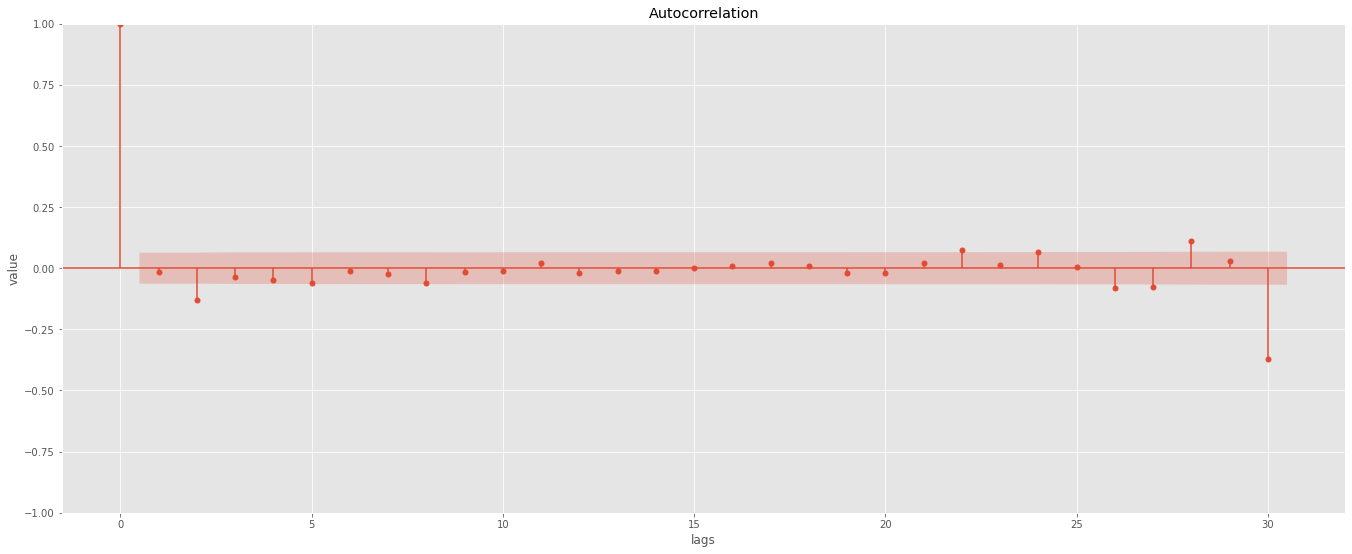

In [307]:
plot_acf(itog, lags=30)
plt.xlabel('lags')
plt.ylabel('value');

тест Ljung-Box

In [308]:
m = 30
n = len(itog)
autocorr = []
for k in range(1,m+1):
    autocorr.append(((itog.autocorr(lag=k))**2)/(n-k))
Q = n*(n+2)*(np.sum(np.array(autocorr)))

In [309]:
from scipy.stats import chi2
df = m

In [310]:
print('Q, равное {} больше, чем критическое значение хи квадрат распределения, равное {}'.format(Q,chi2.ppf(0.95,df)))

Q, равное 203.78472746799616 больше, чем критическое значение хи квадрат распределения, равное 43.77297182574219


Таким образм, гипотеза H0 отвергается => признаётся наличие автокорреляции до 30-го порядка во временном ряду

Бонус! (0.5 балла)

Реализуйте тест Бройша-Годфри. Описание можно почерпнуть из [Википедии](https://en.wikipedia.org/wiki/Breusch–Godfrey_test). Протестируйте остатки на наличие автокорелляций. Изменился ли результат?

In [ ]:
print('Q, равное {} больше, чем критическое значение хи квадрат распределения, равное {}'.format(Q,chi2.ppf(0.95,df)))

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза. Подсчитайте MAE сезонного наивного прогноза (на каждой точке теста -- последнее наблюдение за аналогичный день в предыдущем месяце, 30 дней назад). Справилась ли ваша модель лучше?

In [213]:
# ༼ つ ◕_◕ ༽つ
y_pred = season_pred+trend_pred+resid_pred - 100

In [214]:
naive = NaiveForecaster(strategy="last", sp=30).fit(y_train_decentr-100)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_naive = naive.predict(fh=fh)

In [215]:
from sktime.utils.plotting import plot_series

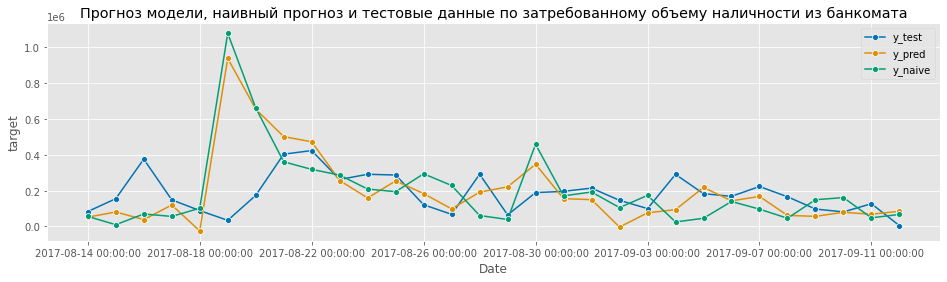

In [228]:
plot_series(y_test, y_pred, y_naive, labels=["y_test", "y_pred", "y_naive"])
plt.title('Прогноз модели, наивный прогноз и тестовые данные по затребованному объему наличности из банкомата')
plt.xlabel('Date');

In [217]:
print('MAE модели: ',MAE(y_test,y_pred))

MAE модели:  122451.65205531102


In [218]:
print('MAE наивного прогноза: ',MAE(y_test,y_naive))

MAE наивного прогноза:  147886.66666666666


Моя модель справилась лучше

### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем одновременно одной ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

In [137]:
from sktime.forecasting.ets import AutoETS

##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

In [138]:
# ༼ つ ◕_◕ ༽つ
y_train, y_test =  temporal_train_test_split(y = atm['target'], test_size=30)
y_train_decentr = y_train + 100

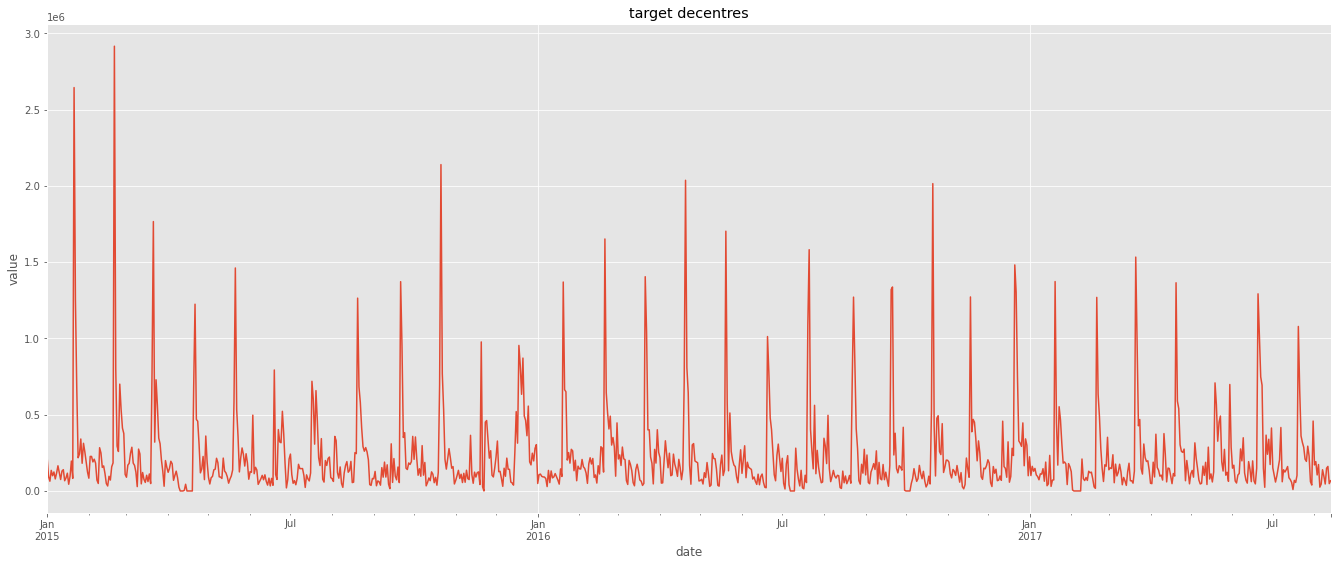

In [229]:
y_train_decentr.plot();
plt.title('target decentres')
plt.xlabel('date')
plt.ylabel('value');

По графику видно, что:

-тренд не экспоненциально возрастающий, так что тренд должен быть аддитивным.

-амплитуда сезонности меняется, так что имеет смысл пробовать как аддитивную, так и мультипликативную сезонность.

-вероятно, ошибка модели может возрастать или убывать с ростом измеряемой величины, так что также имеет смысл пробовать как аддитивную, так и мультипликативную ошибку.

##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [140]:
#༼ つ ◕_◕ ༽つ
class ETS_cv:
    def __init__(self, splitter=CustomCrossVal, window_size = 100, step=30, trend =['add', None], 
                 season = ['add','mul'], error = ['add','mul'], period = 30):
        self.crossval = splitter
        self.window_size = window_size
        self.step = step
        self.trend = trend
        self.season = season
        self.error = error
        self.period = period
        
    def fit(self, X):
        cv = self.crossval(self.window_size, self.step)
        index = cv.split(X)
        mae = []
        for tr in tqdm(self.trend):
            for seas in tqdm(self.season):
                for err in tqdm(self.error):
                    mae_for_params = []
                    for i, j in index:
                        y_train = X[:i]
                        y_test = X[i:j]
                        ets = AutoETS(error=err, trend=tr, damped=True, seasonal=seas, sp=self.period, maxiter = 10**5, n_jobs=-1)
                        ets.fit(y_train)
                        pred = ets.predict(fh=list(range(1,len(y_test)+1)))
                        mae_for_params.append(MAE(y_test, pred))
                    mae.append([np.mean(np.array(mae_for_params)),tr, seas, err])
        return mae            

In [141]:
ets_cv = ETS_cv()

In [142]:
%%time
results = ets_cv.fit(y_train_decentr)

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik




Wall time: 11min 39s


In [143]:
res = np.array(results)[:,0]

In [144]:
results[np.array(list(map((lambda x: float(x)), res))).argmin()]

[148326.8489020362, None, 'add', 'add']

In [145]:
ets = AutoETS(error='add', trend=None, damped=True, seasonal='add', sp=30, maxiter = 10**5, n_jobs=-1)

In [146]:
ets.fit(y_train_decentr, fh = list(range(1,len(y_test)+1)))

AutoETS(maxiter=100000, n_jobs=-1, seasonal='add', sp=30)

In [147]:
pred = ets.predict()

In [151]:
pred

2017-08-14     72221.822321
2017-08-15     76507.901439
2017-08-16     83575.953714
2017-08-17    155918.019634
2017-08-18    353898.041451
2017-08-19    980478.281519
2017-08-20    693657.929698
2017-08-21    478875.474716
2017-08-22    382619.418501
2017-08-23    217319.586994
2017-08-24    178114.595794
2017-08-25    214715.604615
2017-08-26    240747.575455
2017-08-27    224811.444184
2017-08-28    181286.492746
2017-08-29    177083.328657
2017-08-30    282794.935711
2017-08-31    147188.478259
2017-09-01    140253.395734
2017-09-02    115583.561108
2017-09-03    150776.645229
2017-09-04     92019.784414
2017-09-05    173052.592288
2017-09-06    116653.053653
2017-09-07    144903.177056
2017-09-08     95783.124214
2017-09-09    138750.707884
2017-09-10    128694.973468
2017-09-11    101331.776216
2017-09-12     87418.587523
Freq: D, dtype: float64

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне. Они будут использованы в качестве таргета для второй модели. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Результатом пункта должны быть вектор y_train и матрица X_train для модели остатков.

In [152]:
resid = ets.predict_residuals()

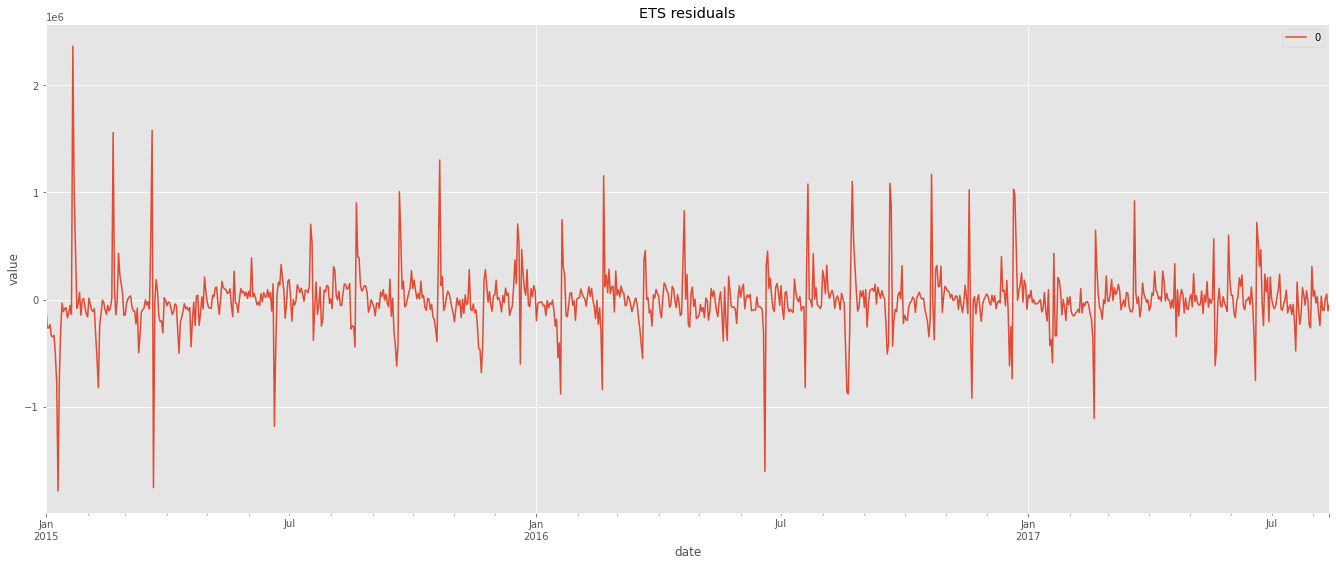

In [230]:
resid.plot()
plt.xlabel('date')
plt.ylabel('value')
plt.title('ETS residuals');

In [165]:
# ༼ つ ◕_◕ ༽つ
X_train, y_train = df_a.drop('residuals',axis=1)[1:len(y_train_decentr)], resid[1:]

In [166]:
y_train

2015-01-02   -264441.200290
2015-01-03   -263315.132035
2015-01-04   -232288.161046
2015-01-05   -336348.169358
2015-01-06   -348690.323292
                  ...      
2017-08-09    -99627.579853
2017-08-10     11559.193321
2017-08-11     52092.701852
2017-08-12   -104217.185046
2017-08-13    -43582.819711
Freq: D, Name: 0, Length: 955, dtype: float64

##### Отбор моделей остатков и кросс-валидация (0.5 баллов)

Отберите 3-4 модели-кандидата для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен 30, как длина теста. Используйте реализованный ранее класс для кросс-валидации. 

In [167]:
# ༼ つ ◕_◕ ༽つ
cv1 = CV_ts(classifier = 'boosting' , param_grid = {'iterations':[100,250], 'learning_rate':[0.05,0.1], 'depth':[5,None]})

boosting = cv1.fit(X_train, y_train)

In [168]:
cv2 =CV_ts(classifier = 'random_forest' , param_grid = {'n_estimators':[100,250], 'max_depth':[None,5], 'min_samples_split':[2]})

random_forest = cv2.fit(X_train, y_train)


In [169]:
cv3 = CV_ts(classifier = 'linreg' , param_grid = {'alpha':[0.5,1,5,10,50,100]})

linreg = cv3.fit(X_train, y_train)

In [170]:
results = [boosting, random_forest, linreg]
minimum = {}
for res, name in zip(results, ['boosting', 'random_forest', 'linreg']):
    minimum[name] = np.array(res)[np.argmin(np.array(res)[:,0]),:] 

##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём трейне. Постройте прогноз на тест с помощью любой многошаговой стратегии. Как и ранее, проще всего использовать прямую.

In [171]:
# ༼ つ ◕_◕ ༽つ
minimum

{'boosting': array([154366.97700742423, 100, 0.05, 5], dtype=object),
 'random_forest': array([165386.98356288808, 100, 5, 2], dtype=object),
 'linreg': array([1.55193462e+05, 1.00000000e+02])}

In [232]:
# ༼ つ ◕_◕ ༽つ
fh = ForecastingHorizon(y_test.index, is_relative=False)
regressor = CatBoostRegressor(iterations = 100, learning_rate = 0.05, depth = 5, loss_function='MAE',verbose = False)
forecaster = make_reduction(regressor, window_length=100,strategy="direct", scitype = 'tabular-regressor')
forecaster.fit(y_train,X_train, fh=fh)

DirectTabularRegressionForecaster(estimator=<catboost.core.CatBoostRegressor object at 0x000001F72404A220>,
                                  window_length=100)

In [233]:
resid_pred = forecaster.predict()

##### Бэктестинг (0.5 балла)

Класс ETS-модели не позволяет напрямую получить прогноз на трейне. Но позволяет сразу получить остатки на трейне. Возьмите эти остатки и вычтите из них прогноз второй модели. Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков. Протестируйте их на наличие серийных автокорреляций любым из тестов, реализованных ранее.

In [234]:
X_train['resid_1'] = y_train.shift(1)
X_train_1, y_train_1 = X_train[1:], y_train[1:]
regressor.fit(X_train_1 , y_train_1);

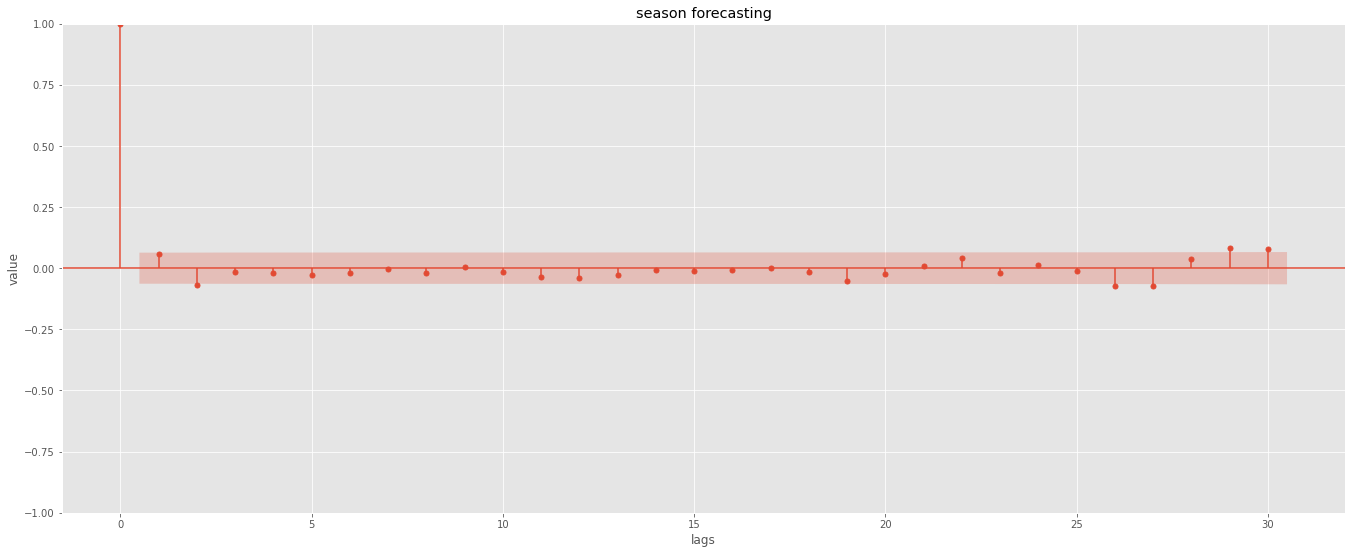

In [235]:
itog = y_train[1:] - regressor.predict(X_train_1)
plot_acf(itog)
plt.title('season forecasting')
plt.xlabel('lags')
plt.ylabel('value');

In [194]:
m = 30
n = len(itog)
autocorr = []
for k in range(1,m+1):
    autocorr.append(((itog.autocorr(lag=k))**2)/(n-k))
Q = n*(n+2)*(np.sum(np.array(autocorr)))
Q

from scipy.stats import chi2
df = m

print('Q, равное {} больше, чем критическое значение хи квадрат распределения, равное {}'.format(Q,chi2.ppf(0.95,df)))

Q, равное 50.96001330801889 больше, чем критическое значение хи квадрат распределения, равное 43.77297182574219


Таким образм, гипотеза H0 отвергается => признаётся наличие автокорреляции до 30-го порядка во временном ряду

##### Результаты (0.6 балла)

Постройте суммарный прогноз ETS-модели и модели остатков на тесте. Визуализируйте прогноз и тестовые значения на графике. Подсчитайте MAE прогноза. Добавьте на график прогноз модели из Блока 1. Какая из двух моделей получилась лучше? Как думаете, почему? Обе ли модели смогли пробить порог сезонной наивной модели?

In [219]:
 y_pred_stl = season_pred+trend_pred+resid_pred - 100

In [220]:
naive = NaiveForecaster(strategy="last", sp=30).fit(y_train_decentr-100)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_naive = naive.predict(fh=fh)

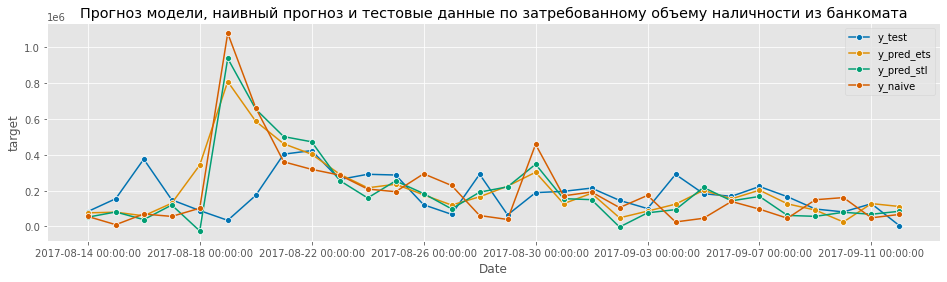

In [236]:
# ༼ つ ◕_◕ ༽つ
ets_itog = pred + resid_pred - 100
plot_series(y_test, ets_itog,y_pred_stl, y_naive, labels=["y_test", "y_pred_ets",'y_pred_stl', "y_naive"] )
plt.title('Прогноз модели, наивный прогноз и тестовые данные по затребованному объему наличности из банкомата')
plt.xlabel('Date');

In [222]:
print('MAE для ETS модели: ',MAE(ets_itog, y_test))

MAE для ETS модели:  102844.54452620997


In [223]:
print('MAE для STL модели: ', MAE(y_pred_stl, y_test))

MAE для STL модели:  122451.65205531102


In [224]:
print('MAE для наивной модели: ', MAE(y_naive, y_test))

MAE для наивной модели:  147886.66666666666


##### Скиньте мем (Бесценно)

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"

Поделитесь, что вам понравилось, а что нет. Это важно